# Convolutional Neural Networks
I this notebook, you'll get familiar with the implementation of CNNs by building and training two CNN networks.

## Preparing the Data
For this taks, you're going to use the [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset. CIFAR10 is a collection of 32 * 32 images in 10 classes. Each image in CIFAR10 has three channels (RGB). You are going to download and prepare the dataset manually.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import os
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
import torchvision
from torchvision.datasets.utils import download_url
from sklearn.model_selection import train_test_split
from torchvision.io import read_image

**For this question, it's highly recommended to use a CUDA-enabled environment.**
We'll check for the availability of GPU and set `device` accordingly.

In [2]:
device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))

In [3]:
url = "http://dl.dropboxusercontent.com/s/dywydpafhaamquw/cifar10.zip"
# Download the dataset using Torchvision's  `download_url`
#############################
# Your code goes here (1 point)
download_url(url, "./")
#############################
!unzip -qq "./cifar10.zip"

100%|██████████| 145997066/145997066 [00:08<00:00, 17779926.33it/s]


Now you are going to implement a custom dataset class for the data you've downloaded. You can implement a custom dataset by inheriting from PyTorch's `Dataset` class. You'll then have to override `__init__`, `__len__`, and `__getitem__` functinos in your custom class. One of the advantages of defining a custom dataset like this is that you have complete control over the data that the dataset returns.

The the dataset you've downloaded has the following structure:
```
cifar10/
    test/
        img_file1.png
        img_file2.png
        ..
        ..
        annotation.csv
    train/
        img_file1.png
        img_file2.png
        ...
        ...
        annotation.csv
```

The `annotation.csv` file in each directory contains a complete list of file names and labels for all the image files in that directory. **Keep in mind that the csv files provided have no header information**.

In [4]:
class CustomCifarDataset(Dataset):
    def __init__(self, annotations_file, root_dir, transform=None):
        """
        `annotation_file`: Path to the csv file with annotations.
        `root_dir`: Directory with all the images.
        `transform`: Transform to be applied.
        """
        self.root_dir = root_dir
        self.transform = transform
        # Read the csv annotation file using pandas' `read_csv` function.
        # (The annotation file consists of n rows. Each row is in the format 
        #    img_file_name, img_label
        #  For example:
        #    airplane_1001, 0
        # )
        #############################
        # Your code goes here (2 points)
        self.annotations = pd.read_csv(annotations_file, header=None)
        #############################

    def __len__(self):
        # Return the number of data points
        #############################
        # Your code goes here (1 point)
        return len(self.annotations)
        #############################

    def __getitem__(self, idx):
        """
        idx: index of the data point referenced.
        """
        # Use `idx` to index the annotation file you parsed in `__init__`.
        # Using `read_image`, load the corresponding image from the disk.
        # Normalize the data to be between 0 and 1.
        # Apply transformation(s) to the image and return the transformed 
        # image and its label.
        #############################
        # Your code goes here (7 points)
        file_name = os.path.join(self.root_dir, self.annotations.iloc[idx, 0])
        image = read_image(file_name)
        label = self.annotations.iloc[idx, 1]

        image = (image - image.min()) / (image.max() - image.min())
        if self.transform:
            image = self.transform(image)

        return image, label
        #############################

In [5]:
test_set = CustomCifarDataset("./cifar10/test/annotation.csv", "./cifar10/test/")
train_set = CustomCifarDataset("./cifar10/train/annotation.csv", "./cifar10/train/")

In [6]:
# Split your training set into train and validation sets (8:2 ratio).
#############################
# Your code goes here (2 points)
train_set, val_set = train_test_split(train_set, test_size=0.2, random_state=42)
#############################

len(train_set), len(val_set), len(test_set)

(40000, 10000, 10000)

In [7]:
# Construct three `DataLoader`s for validation, training, and test sets.
# Use a batch size of 128.
# No shuffling.
#############################
# Your code goes here (5 points)
from torch.utils.data import DataLoader
batch_size = 128
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)
#############################

In [8]:
def train(n_epochs, optimizer, model, loss_fn, train_loader, val_loader):
    model.train()
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            # Compute model's ouptut
            # Move your data to GPU if it's available
            ##############################
            # Your code goes here (5 points)
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            ##############################

            # Compute the loss.
            # Also, use L2 regularization to compute the total loss: `loss + lambda * l2`
            # Set the lambda to 0.001.
            ##############################
            # Your code goes here (7 points)
            loss = loss_fn(outputs, labels) 
            l2_lambda = 0.001
            l2_reg = torch.tensor(0.0, device=device)
            for param in model.parameters():
                l2_reg += torch.norm(param, p=2)
            loss = loss + l2_lambda * l2_reg
            ##############################

            # Do the backprop step.
            ##############################
            # Your code goes here (2 points)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            ##############################
            
            loss_train += loss.item()

        validation_loss = validate(model, val_loader, loss_fn)
        print('Epoch {}, Training loss {}, Validation loss {}'.format(epoch, loss_train / len(train_loader), validation_loss))


In [9]:
def validate(model, val_loader, loss_fn):
        with torch.no_grad():
            val_loss = 0.0
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                # Compute the loss
                ##############################
                # Your code goes here (9 points)
                outputs = model(imgs)
                loss = loss_fn(outputs, labels)
                ##############################
                val_loss += loss.item()

        return val_loss / len(val_loader)

**Answer the following questions (5 points):**
- What is `torch.no_grad()` and when is it used?


*The use of `torch.no_grad()` is where every tensor inside the loop will have requires_grad set to False. It means any tensor with gradient currently attached with the current computational graph is now detached from the current graph. We no longer be able to compute the gradients with respect to this tensor.
It is used in cases when we do not need to compute the gradients in backpropagation for example when evaluating model and in inference time. Also when we want to freeze a pretrained model.*

- What do the instructions `model.eval()` and `model.train()` do?

*`model.eval()`: This method sets the model to evaluation mode. In evaluation mode, the model behaves differently compared to training mode. Specifically, it disables certain operations that are typically used during training, such as dropout and batch normalization. This is because during evaluation or inference, we are interested in obtaining the model's predictions and evaluating its performance, rather than updating the model's parameters based on gradients. By disabling these operations, we ensure that the model's behavior during inference is consistent and does not introduce additional randomness.*

*`model.train()`: This method sets the model back to training mode. In training mode, the model enables all the operations that are typically used during training, such as dropout and batch normalization. This allows the model to learn from the training data, compute gradients, and update its parameters based on the computed gradients during the backpropagation step.*


   

In [10]:
def test(model, test_loader):
  model.eval()
  correct = 0
  total = 0
  with torch.no_grad():
    for imgs, labels in test_loader:
      imgs, labels = imgs.to(device), labels.to(device)
      # Compute the predicted class and update 
      # `total` and `correct` accordingly
      ##############################  
      # Your code goes here (9 points)
      outputs = model(imgs)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
      ##############################

    return correct / total

## Creating the Model
Now you're going to build the CNN model. The overall architecture of the model you are going to implement is depicted in the following picture (All of the max poolings used have a stride of 2*2):

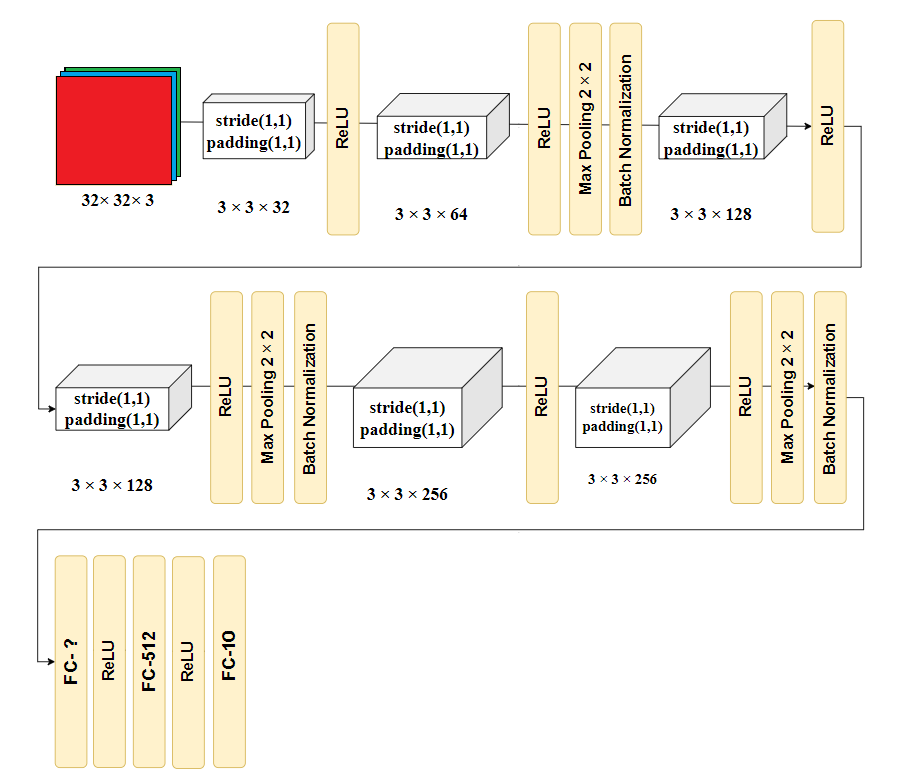

In [11]:
class SimpleCNN(nn.Module):
    def __init__(self, in_channels, out_dim):
        """
        `in_channels`: Number of channels for input instances
        `out_dim`    : The network's output dimensions
        """
        super().__init__()
        self.relu = nn.ReLU()            # Apply for all the layers (except the last one)
        self.maxpool = nn.MaxPool2d(2,2) # Apply for conv2, conv4, and conv6
        
        self.bn1 = nn.BatchNorm2d(64) # Apply for conv2
        self.bn2 = nn.BatchNorm2d(128) # Apply for conv4
        self.bn3 = nn.BatchNorm2d(256) # Apply for conv6
        
        self.conv1 = self.conv2 = self.conv3 = self.conv4 = self.conv5 = self.conv6 = None
        self.fc1 = self.fc2 = self.fc3 = None

        
        # Create five 2D convolutional layers (conv1 through conv6)
        # Set the padding and stride to 1 for all the layers.
        # Use 3*3 kernels.
        ##############################
        # Your code goes here (10 points)
        self.conv1 = nn.Conv2d(in_channels, 32, 3, padding=1, stride=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1, stride=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1, stride=1)
        self.conv4 = nn.Conv2d(128, 128, 3, padding=1, stride=1)
        self.conv5 = nn.Conv2d(128, 256, 3, padding=1, stride=1)
        self.conv6 = nn.Conv2d(256, 256, 3, padding=1, stride=1)
        ##############################

        self.flatten = nn.Flatten()
        
        # According to the output dimensions of `conv6` and the `in_features` value for fc2,
        # set `in_features` and `out_features` for fc1 to proper values. 
        ##############################
        # your code goes here (5 points)
        self.fc1 = nn.Linear(256*4*4,1024)
        #############################
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, out_dim)
        
    def forward(self, x):
        # Move x thorugh the network and return the output
        # according to the architecture.
        ##############################
        # Your code goes here (10 points)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.bn1(x)

        x = self.conv3(x)
        x = self.relu(x)
        x = self.conv4(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.bn2(x)
        
        x = self.conv5(x)
        x = self.relu(x)
        x = self.conv6(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.bn3(x)

        x = self.flatten(x)
        
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        out = self.fc3(x)
        ##############################
        return out

In [12]:
model = SimpleCNN(3, 10).to(device=device)

In [13]:
# Use Adam optimizer with a learning rate of 0.001 as the optimizer.
# Use CrossEntropy as loss function.
##############################
# Your code goes here (5 points)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()
##############################
train(
    n_epochs = 10,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
    val_loader=val_loader
)

Epoch 1, Training loss 1.3132142211301638, Validation loss 0.9220279636262338
Epoch 2, Training loss 0.8720173085459505, Validation loss 0.7520528669598736
Epoch 3, Training loss 0.6716778611603637, Validation loss 0.7628439317775678
Epoch 4, Training loss 0.5322252963297665, Validation loss 0.7640460533431813
Epoch 5, Training loss 0.4444192388948922, Validation loss 0.8285593835613395
Epoch 6, Training loss 0.3880178557988554, Validation loss 0.8254995761038382
Epoch 7, Training loss 0.34605607328513943, Validation loss 0.8718408451804632
Epoch 8, Training loss 0.3265582023146815, Validation loss 0.9637380989292
Epoch 9, Training loss 0.3138759386615631, Validation loss 1.0426507818547985
Epoch 10, Training loss 0.31256269646909673, Validation loss 1.0232939169376711


In [14]:
test(model, test_loader)

0.7952

## Visualizing Feature Maps

The feature maps, also known as activation maps, record what happens when the filters are applied to an input.


In this section, you're going to visualize feature maps for a random input image for layers `conv1` through `conv6`. 

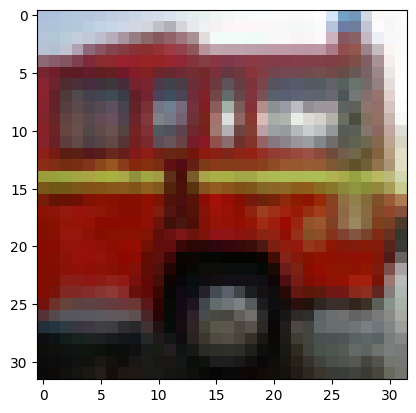

In [32]:
import random
img = train_set[random.randint(0, len(train_set))][0]
plt.imshow(img.permute(1,2,0))
plt.show()

In [33]:
conv_layers = [model.conv1, model.conv2, model.conv3, model.conv4, model.conv5, model.conv6]

# Pass `img` thorough the layers and save the results for each layer in `output`.
##############################
# Your code goes here (5 points)
image = img.to(device)
outputs = []
for layer in conv_layers:
    image = layer(image)
    outputs.append(image)
##############################
len(outputs)

6

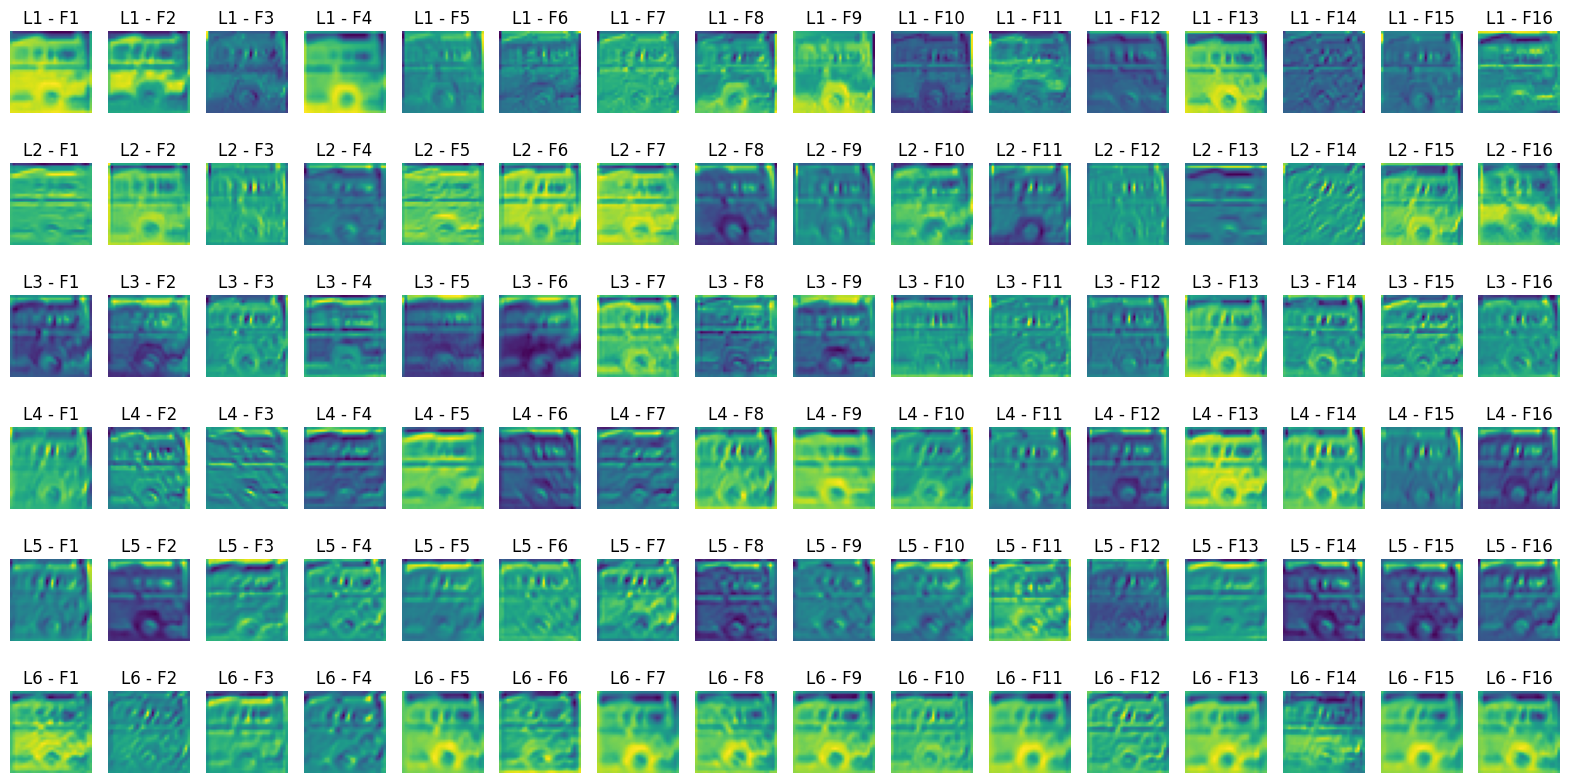

In [34]:
# Visualize the output for the first 16 filters of each layer.
##############################
# Your code goes here (5 points)
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20, 10))

for i, output in enumerate(outputs):
    output_16 = output[:16, :]
    for j in range(output_16.shape[0]):
        feature_map = output_16[j, :].unsqueeze(0)
        plt.subplot(len(outputs), 16, i*16+j+1)
        plt.title(f'L{i+1} - F{j+1}')
        plt.imshow(feature_map.cpu().squeeze().detach().numpy())
        plt.axis('off')

plt.show()
##############################

**Answer the following question (5 points):**
- Which one of the feature maps you visualized do you find helpful for the task? Which ones you don't find helpful?

In general, we know that feature maps that capture edges, corners, textures, or other relevant visual patterns that are important for the task are helpful. In this example feature maps showing edges or textures of car body, car wheel, or car windows are helpful. As we can see feature maps like L1-F4, L1-F9,L1-F13,...,L6-F9 are detecting car wheel. In addition Feature maps like L1-F6, ..., L5-F14-16 are detecting car's body shape. 

On the other hand, It seems that feature maps like L3-F6 focus on color of car or L2-F14 which has not obvious focus may not be useful.

Overall, it is obvious that the feature maps of last layers contain high level features that capture more abstract representations of the input data and are more helpful.
